# Perceptual Attack

Apply neural perceptual attack to images taken from: Cassidy Laidlaw, Sahil Singla, and Soheil Feizi. ["Perceptual adversarial robustness: Defense against unseen threat models."](https://arxiv.org/abs/2006.12655) arXiv preprint arXiv:2006.12655 (2020).

## Problem Description

Given a classifier $f$ which maps any input image $x \in X$ to its label $y = f(x) \in Y$. The goal of neural perceptual attack is to find an input $\widetilde{x}$ that is perceptually similar to the original input $x$ but can fool the classifier $f$. This can be formulated as:

$$\max_{\widetilde{x}} L (f(\widetilde{x}),y),$$
$$\text{s.t.}\;\; d(x,\widetilde{x}) = ||\phi(x) - \phi (\tilde{x}) ||_{2} \leq \epsilon$$
Here $$L (f({x}),y) = \max_{i\neq y} (z_i(x) - z_y(x) ),$$
where $z_i(x)$ is the $i$-th logit output of $f(x)$, and $\phi(\cdot)$ is a function that maps the input $x$ to  normalized, flattened activations

## Modules Importing
Import all necessary modules and add PyGRANSO src folder to system path. 

NOTE: the perceptual advex package (https://github.com/cassidylaidlaw/perceptual-advex.git) is required to calculate the distance 

In [1]:
# install required package
try:
    import perceptual_advex
except ImportError:
    !pip install perceptual-advex

In [2]:
import time
import torch
import sys
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch
from perceptual_advex.utilities import get_dataset_model
from perceptual_advex.perceptual_attacks import get_lpips_model
from perceptual_advex.distances import normalize_flatten_features
import gc

## Download Pretrained Model

In [3]:
import os

# Download ResNet model
if not os.path.exists('data/checkpoints/cifar_pgd_l2_1.pt'):
    !mkdir -p data/checkpoints
    !curl -o data/checkpoints/cifar_pgd_l2_1.pt https://perceptual-advex.s3.us-east-2.amazonaws.com/cifar_pgd_l2_1_cpu.pt

## Data Initialization 

Specify torch device, neural network architecture, and generate data.

NOTE: please specify path for downloading data.

Use GPU for this problem. If no cuda device available, please set *device = torch.device('cpu')*

In [4]:
device = torch.device('cuda')

dataset, model = get_dataset_model(
dataset='cifar',
arch='resnet50',
checkpoint_fname='data/checkpoints/cifar_pgd_l2_1.pt',
)
model = model.to(device=device, dtype=torch.double)
# Create a validation set loader.
batch_size = 1
_, val_loader = dataset.make_loaders(1, batch_size, only_val=True, shuffle_val=False)

inputs, labels = next(iter(val_loader))

# All the user-provided data (vector/matrix/tensor) must be in torch tensor format. 
# As PyTorch tensor is single precision by default, one must explicitly set `dtype=torch.double`.
# Also, please make sure the device of provided torch tensor is the same as opts.torch_device.
inputs = inputs.to(device=device, dtype=torch.double)
labels = labels.to(device=device)

# externally-bounded attack: AlexNet for constraint while ResNet for objective
lpips_model = get_lpips_model('alexnet_cifar', model).to(device=device, dtype=torch.double)

# Don't reccoment use in the current version. self-bounded attack: AlexNet for both constraint and objective
# model = get_lpips_model('alexnet_cifar', model).to(device=device, dtype=torch.double)

# attack_type = 'L_2'
# attack_type = 'L_inf'
attack_type = 'Perceptual'

=> loading checkpoint 'data/checkpoints/cifar_pgd_l2_1.pt'
==> Preparing dataset cifar..
Files already downloaded and verified


## Function Set-Up

Encode the optimization variables, and objective and constraint functions.

Note: please strictly follow the format of comb_fn, which will be used in the PyGRANSO main algortihm.

In [5]:
# variables and corresponding dimensions.
var_in = {"x_tilde": list(inputs.shape)}

def MarginLoss(logits,labels):
    correct_logits = torch.gather(logits, 1, labels.view(-1, 1))
    max_2_logits, argmax_2_logits = torch.topk(logits, 2, dim=1)
    top_max, second_max = max_2_logits.chunk(2, dim=1)
    top_argmax, _ = argmax_2_logits.chunk(2, dim=1)
    labels_eq_max = top_argmax.squeeze().eq(labels).float().view(-1, 1)
    labels_ne_max = top_argmax.squeeze().ne(labels).float().view(-1, 1)
    max_incorrect_logits = labels_eq_max * second_max + labels_ne_max * top_max
    loss = -(max_incorrect_logits - correct_logits).clamp(max=1).squeeze().sum()
    return loss

def user_fn(X_struct,inputs,labels,lpips_model,model):
    adv_inputs = X_struct.x_tilde
    
    # objective function
    # 8/255 for L_inf, 1 for L_2, 0.5 for PPGD/LPA
    if attack_type == 'L_2':
        epsilon = 1
    elif attack_type == 'L_inf':
        epsilon = 8/255
    else:
        epsilon = 0.5

    logits_outputs = model(adv_inputs)

    f = MarginLoss(logits_outputs,labels)

    # inequality constraint
    ci = pygransoStruct()
    if attack_type == 'L_2':
        ci.c1 = torch.norm((inputs - adv_inputs).reshape(inputs.size()[0], -1)) - epsilon
    elif attack_type == 'L_inf':
        # ci.c1 = torch.norm((inputs - adv_inputs).reshape(inputs.size()[0], -1), float('inf')) - epsilon
        linf_distance = torch.amax(torch.abs(inputs-adv_inputs).reshape(inputs.size()[0], -1))
        ci.c1 = linf_distance - epsilon
    else:
        input_features = normalize_flatten_features( lpips_model.features(inputs)).detach()
        adv_features = lpips_model.features(adv_inputs)
        adv_features = normalize_flatten_features(adv_features)
        lpips_dists = (adv_features - input_features).norm(dim=1)
        ci.c1 = lpips_dists - epsilon
    
    # equality constraint 
    ce = None

    return [f,ci,ce]

comb_fn = lambda X_struct : user_fn(X_struct,inputs,labels,lpips_model,model)

## User Options
Specify user-defined options for PyGRANSO 

In [6]:
opts = pygransoStruct()
opts.torch_device = device
opts.maxit = 100
opts.opt_tol = 1e-6
opts.print_frequency = 1
opts.x0 = torch.reshape(inputs,(torch.numel(inputs),1))

## Main Algorithm

In [7]:
start = time.time()
soln = pygranso(var_spec = var_in,combined_fn = comb_fn,user_opts = opts)
end = time.time()
print("Total Wall Time: {}s".format(end - start))

/home/buyun/anaconda3/envs/cuosqp_pygranso/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)




╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

## Batch Attacks

Apply attacks to multiple images by repeating above steps and calculate the success rate

In [8]:
total_count = 50
total_diff = 0
original_count = 0
attack_count = 0
total_time = 0
total_iterations = 0  
i = 0
it = iter(val_loader)

for i in range(total_count):
    # Get a batch from the validation set.
    inputs, labels = next(it)
    inputs = inputs.to(device=device, dtype=torch.double)
    labels = labels.to(device=device)

    # variables and corresponding dimensions.
    var_in = {"x_tilde": list(inputs.shape)}

    opts.x0 = torch.reshape(inputs,(torch.numel(inputs),1))
    # suppress output
    opts.print_level = 0

    pred_labels = model(inputs).argmax(1)
    if pred_labels == labels:
        original_count += 1
    else:
        continue
    
    start = time.time()
    soln = pygranso(var_spec = var_in,combined_fn = comb_fn,user_opts = opts)
    end = time.time()
    
    # Garbage Collector
    gc.collect()
    
    print("attack image # %d"%i)
    
    total_time += end - start
    total_iterations += soln.fn_evals

    final_adv_input = torch.reshape(soln.final.x,inputs.shape)
    pred_labels2 = model(final_adv_input.to(device=device, dtype=torch.double)).argmax(1)

    if pred_labels2 == labels:
        attack_count += 1
        
    if attack_type == 'L_2':
            diff = torch.norm((inputs.to(device=device, dtype=torch.double) - final_adv_input).reshape(inputs.size()[0], -1))
    elif attack_type == 'L_inf':
        diff = ( torch.norm((inputs.to(device=device, dtype=torch.double) - final_adv_input).reshape(inputs.size()[0], -1), float('inf') ) )
    else:
        input_features = normalize_flatten_features( lpips_model.features(inputs)).detach()
        adv_features = lpips_model.features(final_adv_input)
        adv_features = normalize_flatten_features(adv_features)
        lpips_dists = torch.mean((adv_features - input_features).norm(dim=1))
        diff = lpips_dists

    total_diff += diff

print("\n\n\nModel train acc on the original image = {}".format(( original_count/total_count )))
print("Success rate of attack = {}".format( (original_count-attack_count)/original_count ))
print("Average distance between attacked image and original image = {}".format(total_diff/original_count))
print("Average run time of PyGRANSO = {}s, mean f_eval = {} iters".format(total_time/original_count,total_iterations/original_count))

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


attack image # 0
attack image # 8
attack image # 11
attack image # 14
attack image # 18
attack image # 23
attack image # 28
attack image # 34
attack image # 38
attack image # 42
attack image # 45
attack image # 46



Model train acc on the original image = 0.24
Success rate of attack = 1.0
Average distance between attacked image and original image = 0.4919106732232837
Average run time of PyGRANSO = 3.276595413684845s, mean f_eval = 29.666666666666668 iters


## ImageNet Datasets

*(Optional)* Perceptual Attack on ImageNet datasets

### Modules Importing

Import all necessary modules and add PyGRANSO src folder to system path.

NOTE: the perceptual advex package (https://github.com/cassidylaidlaw/perceptual-advex.git) is required to calculate the distance

In [9]:
import time
import torch
import sys
## Adding PyGRANSO directories. Should be modified by user
sys.path.append('/home/buyun/Documents/GitHub/PyGRANSO')
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from perceptual_advex.distances import normalize_flatten_features
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
from torchvision.models import resnet50
import os
import numpy as np

### Model Initialization
Specify torch device, neural network architecture.

NOTE: please specify path for downloading data.

Use GPU for this problem. If no cuda device available, please set device = torch.device('cpu')

In [10]:
device = torch.device('cuda')

class ResNet_orig_LPIPS(nn.Module):
    def __init__(self, num_classes, pretrained=False):
        super().__init__()
        pretrained = bool(pretrained)
        print("Use pytorch pretrained weights: [{}]".format(pretrained))
        self.back = resnet50(pretrained=pretrained)
        self.back.fc = nn.Linear(2048, 
                                 num_classes)
        # ===== Truncate the back and append the model to enable attack models
        model_list = list(self.back.children())
        self.head = nn.Sequential(
            *model_list[0:4]
        )
        self.layer1 = model_list[4]
        self.layer2 = model_list[5]
        self.layer3 = model_list[6]
        self.layer4 = model_list[7]
        self.tail = nn.Sequential(
            *[model_list[8],
              nn.Flatten(),
              model_list[9]]
            )    
        # print()    

    def features(self, x):
        """
            This function is called to produce perceptual features.
            Output ==> has to be a tuple of conv features.
        """
        x = x.type(self.back.fc.weight.dtype)
        x = self.head(x)
        x_layer1 = self.layer1(x)
        x_layer2 = self.layer2(x_layer1)
        x_layer3 = self.layer3(x_layer2)
        x_layer4 = self.layer4(x_layer3)
        return x_layer1, x_layer2, x_layer3, x_layer4
    
    def classifier(self, last_layer):
        last_layer = self.tail(last_layer)
        return last_layer
    
    def forward(self, x):
        return self.classifier(self.features(x)[-1])
    
    def features_logits(self, x):
        features = self.features(x)
        logits = self.classifier(features[-1])
        return features, logits

base_model = ResNet_orig_LPIPS(num_classes=100,pretrained=False).to(device)

Use pytorch pretrained weights: [False]


### Download Pretrained Model
please download our pretrained model from the Google Drive [https://drive.google.com/file/d/1TZoKfVrqLgwKLa5-Y69uVOYb1xtOp8ty/view?usp=sharing] and add it to the "data/checkpoints/" path

In [11]:
import os

# Download Pretrained model
if not os.path.exists('data/checkpoints/checkpoint.pth'):
    !mkdir -p data/checkpoints
        
pretrained_path = os.path.join("data/checkpoints/","checkpoint.pth")
state_dict = torch.load(pretrained_path)["model_state_dict"]
base_model.load_state_dict(state_dict)

<All keys matched successfully>

### Data Initialization
Download ImageNet 2012 validation data from [https://www.image-net.org/download.php], and put it under the directory

In [12]:
# The ImageNet dataset is no longer publicly accessible. 
# You need to download the archives externally and place them in the root directory
valset = datasets.ImageNet('/home/buyun/Documents/datasets/ImageNet/', split='val', transform=transforms.Compose([transforms.CenterCrop(224),transforms.ToTensor()]))
val_loader = torch.utils.data.DataLoader(valset, batch_size=1,shuffle=False, num_workers=0, collate_fn=None, pin_memory=False,)

# inputs, labels = next(iter(val_loader))

i=0
for inputs, labels in val_loader:
    i+=1
    if i > 2:
        break

# All the user-provided data (vector/matrix/tensor) must be in torch tensor format.
# As PyTorch tensor is single precision by default, one must explicitly set `dtype=torch.double`.
# Also, please make sure the device of provided torch tensor is the same as opts.torch_device.
inputs = inputs.to(device=device, dtype=torch.double)
labels = labels.to(device=device)

### Function Set-Up
Encode the optimization variables, and objective and constraint functions.

Note: please strictly follow the format of comb_fn, which will be used in the PyGRANSO main algortihm.

In [13]:
# variables and corresponding dimensions.
var_in = {"x_tilde": list(inputs.shape)}

def MarginLoss(logits,labels):
    correct_logits = torch.gather(logits, 1, labels.view(-1, 1))
    max_2_logits, argmax_2_logits = torch.topk(logits, 2, dim=1)
    top_max, second_max = max_2_logits.chunk(2, dim=1)
    top_argmax, _ = argmax_2_logits.chunk(2, dim=1)
    labels_eq_max = top_argmax.squeeze().eq(labels).float().view(-1, 1)
    labels_ne_max = top_argmax.squeeze().ne(labels).float().view(-1, 1)
    max_incorrect_logits = labels_eq_max * second_max + labels_ne_max * top_max
    loss = -(max_incorrect_logits - correct_logits).clamp(max=1).squeeze().sum()
    return loss

def user_fn(X_struct, inputs, labels, lpips_model, model, attack_type, eps=0.5):
    adv_inputs = X_struct.x_tilde
    epsilon = eps
    logits_outputs = model(adv_inputs)
    f = -torch.nn.functional.cross_entropy(logits_outputs,labels)

    # inequality constraint
    ci = pygransoStruct()
    if attack_type == 'L_2':
        ci.c1 = torch.norm((inputs - adv_inputs).reshape(inputs.size()[0], -1)) - epsilon
    elif attack_type == 'L_inf':
        ci.c1 = torch.norm((inputs - adv_inputs).reshape(inputs.size()[0], -1), float('inf')) - epsilon
    else:
        input_features = normalize_flatten_features( lpips_model.features(inputs)).detach()
        adv_features = lpips_model.features(adv_inputs)
        adv_features = normalize_flatten_features(adv_features)
        lpips_dists = (adv_features - input_features).norm(dim=1)
        ci.c1 = lpips_dists - epsilon

    # equality constraint
    ce = None
    return [f,ci,ce]

attack_type = "Perceptual"
var_in = {"x_tilde": list(inputs.shape)}

comb_fn = lambda X_struct : user_fn(X_struct, inputs, labels, lpips_model=base_model, model=base_model, attack_type=attack_type, eps=0.25)


### User Options
Specify user-defined options for PyGRANSO

In [14]:
opts = pygransoStruct()
opts.torch_device = device
opts.maxit = 50
opts.opt_tol = 1e-4
opts.viol_ineq_tol = 1e-4

opts.print_frequency = 1
opts.limited_mem_size = 100
opts.x0 = torch.reshape(inputs,(torch.numel(inputs),1))

### Main Algorithm

In [15]:
start = time.time()
soln = pygranso(var_spec = var_in,combined_fn = comb_fn,user_opts = opts)
end = time.time()
print("Total Wall Time: {}s".format(end - start))



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

  42 ║ 0.430467 │ -2.28013898502 ║ -5.29768085480 ║ 3.39e-04 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.397319   ║ 
  43 ║ 0.430467 │ -2.28024609279 ║ -5.29762601852 ║ 2.08e-04 │   -  ║ S  │     2 │ 0.500000 ║     1 │ 0.323241   ║ 
  44 ║ 0.430467 │ -2.28044597618 ║ -5.29789733887 ║ 1.25e-04 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.235920   ║ 
  45 ║ 0.430467 │ -2.28060165943 ║ -5.29813098907 ║ 7.00e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.348329   ║ 
  46 ║ 0.430467 │ -2.28078929003 ║ -5.29859781265 ║ 8.33e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.307751   ║ 
  47 ║ 0.430467 │ -2.28099150593 ║ -5.29904174805 ║ 7.22e-05 │   -  ║ S  │     2 │ 0.500000 ║     1 │ 0.280139   ║ 
  48 ║ 0.430467 │ -2.28100859374 ║ -5.29910373688 ║ 8.18e-05 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.304666   ║ 
  49 ║ 0.430467 │ -2.28118402230 ║ -5.29971647263 ║ 1.70e-04 │   -  ║ S  │     1 │ 1.000000 ║     1 │ 0.280201   ║ 
  50 ║ 0.430467 │ -2.28143626977 ║ -5.30004692078 ║ 6.01e-05 │   -  ║ S 

### Results Visualization
Visualize the original image and the perceptual attacked image

/home/buyun/anaconda3/envs/cuosqp_pygranso/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


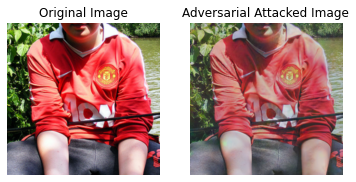

In [16]:
import matplotlib.pyplot as plt

def rescale_array(array):
    ele_min, ele_max = np.amin(array), np.amax(array)
    array = (array - ele_min) / (ele_max - ele_min)
    return array

def tensor2img(tensor):
    tensor = torch.nn.functional.interpolate(
        tensor,
        scale_factor=3,
        mode="bilinear"
    )
    array = tensor.detach().cpu().numpy()[0, :, :, :]
    array = np.transpose(array, [1, 2, 0])
    return array

final_adv_input = torch.reshape(soln.final.x,inputs.shape)

ori_image = rescale_array(tensor2img(inputs))
adv_image = rescale_array(tensor2img(final_adv_input))

f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow(ori_image)
plt.title('Original Image')
plt.axis('off')
f.add_subplot(1,2,2)
plt.imshow(adv_image)
plt.title('Adversarial Attacked Image')
plt.axis('off')
plt.show()